In [143]:
# We use these to constuct the Petrinet representation of the system
import snakes.plugins
snakes.plugins.load('gv', 'snakes.nets', 'nets')
from nets import *

# We will use these to solve the odes we develop
import scipy, scipy.integrate, scipy.optimize, pylab, copy
import numpy as np

# We will use Matplotlib to make a 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from matplotlib.colors import PowerNorm

# We will make use of sliders
import panel as pn
pn.extension()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<module 'snakes.nets' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/snakes/nets.py'>

In [144]:
# Creating an empty PetriNet

n = PetriNet("repressilator")

# creating places with arbitrary tokens

n.add_place(Place('src',[1e8]))
n.add_place(Place('x1', [3]))
n.add_place(Place('x2', [4]))
n.add_place(Place('x3', [5]))
n.add_place(Place('m1', [300]))
n.add_place(Place('m2', [400]))
n.add_place(Place('m3', [500]))
n.add_place(Place('sink', [0]))

# create reactions

# rxns involving the proteins
n.add_transition(Transition('t2', Expression('x1_prod') ))
n.add_transition(Transition('t6', Expression('x2_prod') ))
n.add_transition(Transition('t10', Expression('x3_prod') ))
n.add_transition(Transition('t3', Expression('x1_deg') ))
n.add_transition(Transition('t7', Expression('x2_deg') ))
n.add_transition(Transition('t11', Expression('x3_deg') ))

# rxns involving mRNAs
n.add_transition(Transition('t1', Expression('m1_prod') ))
n.add_transition(Transition('t5', Expression('m2_prod') ))
n.add_transition(Transition('t9', Expression('m3_prod') ))
n.add_transition(Transition('t4', Expression('m1_deg') ))
n.add_transition(Transition('t8', Expression('m2_deg') ))
n.add_transition(Transition('t12', Expression('m3_deg') ))

# add arcs to link up transitions

n.add_input('x1', 't3', Value(1))
n.add_output('sink', 't3', Value(1))
n.add_output('x1', 't2', Value(1))

n.add_output('x2', 't6', Value(1))
n.add_input('x2', 't7', Value(1))
n.add_output('sink', 't7', Value(1))

n.add_output('x3', 't10', Value(1))
n.add_input('x3', 't11', Value(1))
n.add_output('sink', 't11', Value(1))

n.add_input('m1', 't2', Value(1))
n.add_output('m1', 't2', Value(1))
n.add_input('x1', 't5', Value(1))
n.add_input('x3', 't1', Value(1))
n.add_input('src', 't1', Value(1))
n.add_output('m1', 't1', Value(1))
n.add_input('m1', 't4', Value(1))
n.add_output('sink', 't4', Value(1))
n.add_output('sink', 't8', Value(1))
n.add_input('src', 't5', Value(1))
n.add_output('m2', 't5', Value(1))
n.add_input('m2', 't8', Value(1))
n.add_output('sink', 't12', Value(1))
n.add_input('src', 't9', Value(1))
n.add_input('x2', 't9', Value(1))
n.add_output('m3', 't9', Value(1))
n.add_input('m3', 't12', Value(1))
n.add_input('m3', 't10', Value(1))
n.add_output('m3', 't10', Value(1))
n.add_input('m2', 't6', Value(1))
n.add_output('m2', 't6', Value(1))

Graph(['node_16', 'node_7', 'node_3', 'node_11', 'node_13', 'node_10', 'node_15', 'node_14', 'node_17', 'node_6', 'node_19', 'node_1', 'node_4', 'node_8', 'node_2', 'node_9', 'node_18', 'node_12', 'node_5', 'node_0'], [])

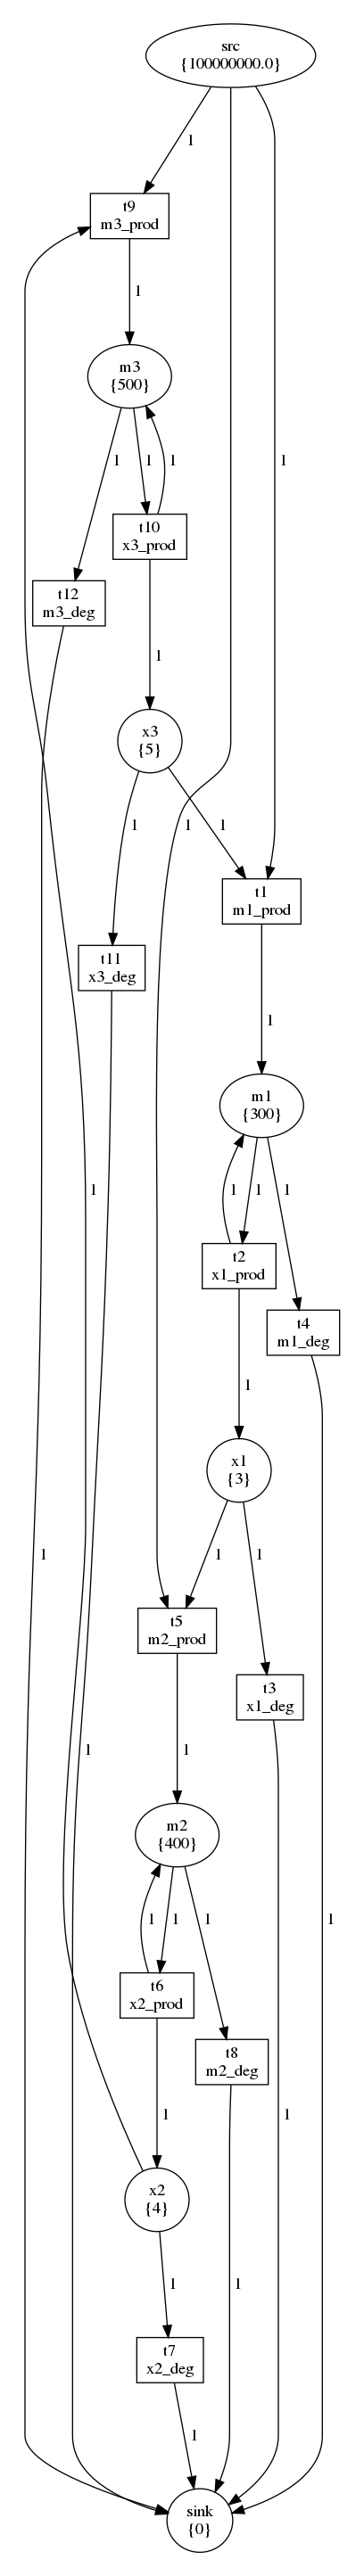

In [11]:
n.draw("repressilator.png")

#display image
from IPython.display import Image
Image(filename='repressilator.png') 

In [140]:
# <codecell>
class HillRepressilator:
    def __init__(self, gamma_m, gamma_p, del_m, del_p, n, k, y0):
        """
        Initiate a HillRepressilator (i.e., a Repressilator where the
        protein-DNA interaction is subsumed in a simple Hill function).
        Instance parameters are initialized based on the input parameters
        Also store the bare parameters (K_m, K_p, T, K_b) so that you can
        convert from scaled times and concentrations back to bare times
        and concentrations if desired.
        """
        self.gamma_m = 10**gamma_m
        self.gamma_p = 10**gamma_p
        self.del_m=del_m
        self.del_p=10**del_p
        self.n = n
        self.k = k
        self.y0_6 = y0



    @staticmethod
    def dydt(y, t, gamma_m, gamma_p, del_m, del_p, n, k):
        """Define the right-hand-side of the Repressilator equations
        for use with scipy.integrate.odeint.  Since this needs to be called
        as if it were a standalone function, and not an instance method
        (which would implicitly assume the first argument is the instance
        self), we declare this as a staticmethod so that self is not passed
        as an implicit argument.  Alternatively, one could define dydt
        outside the HillRepressilator class, but this is cleaner."""
        
        """
    Returns 6-array of (dm_1/dt, dm_2/dt, dm_3/dt, dx_1/dt, dx_2/dt, dx_3/dt)
    """
        m_1, m_2, m_3, x_1, x_2, x_3 = y
    
        return np.array(
            [
                gamma_m/(1+(k*(x_3**n))) - del_m*m_1,
                gamma_m/(1+(k*(x_1**n))) - del_m*m_2,
                gamma_m/(1+(k*(x_2**n))) - del_m*m_3,
                gamma_p *m_1 - del_p*x_1,
                gamma_p *m_2 - del_p*x_2,
                gamma_p *m_3 - del_p*x_3
            ]
        )
        
        
    def run(self, y0, T, nT, params):
        """
        run(self, )
        Run the Repressilator for the specified amount of time T, returning
        output for a specified array of times.  Store the trajectory returned
        by odeint in the instance variable self.traj, concatenating the result
        to the existing self.traj if a previous trajectory had been created.
        """
        self.args = params
        self.time = np.linspace(0, T, nT)
        self.x = scipy.integrate.odeint(self.dydt, self.y0_6, self.time, self.args)
        m1, m2, m3, x1, x2, x3 = self.x.transpose()
        self.traj = self.x.transpose()
        
        return [self.time, self.traj]
        
        
    def find_steady_state(self,alpha=None, n=None, alpha0=None):
        """Return the steady-state concentration of mRNAs and proteins
        (i.e., an array of length 6) for the specified parameters
        alpha, n, alpha0.  Use scipy.optimize.fsolve."""
        pass
    

    def in_steady_state(self):
        """Return True or False indicating whether the current state of
        the system is in the steady-state.  Do this by evaluating the
        instantaneous time derivative of the equations of motion and
        checking whether the vector norm of the instantaneous velocity
        is sufficiently small (e.g., smaller than 1.0e-3)."""
        pass

    def rescale_trajectory(self):
        """Return a scaled trajectory from the data contained in the
        self.traj variable.  This undoes the scaling transformation into
        natural units, producing a 6-component trajectory
        containing raw molecular concentrations."""
        pass

    def plot(self, time, soln, show_proteins=True, show_mRNAs=False):
        """Plot the trajectory of the Repressilator, optionally showing
        either the protein concentrations or the mRNA concentrations,
        in either dimensionless or rescaled units."""
        
        number = 6
        cmap = plt.get_cmap('gnuplot')
        colors = [cmap(i) for i in np.linspace(0, 1, number)]
    
        
        m1, m2, m3, x1, x2, x3 = soln

        if show_proteins:
            plt.plot(time, x1, LineWidth=2, color=colors[0], label="x1")
            plt.plot(time, x2, LineWidth=2, color=colors[2], label="x2")
            plt.plot(time, x3, LineWidth=2, color=colors[4], label="x3")
            plt.legend(loc='best')
            plt.show()

            
        if show_mRNAs:
            plt.plot(time, m1, LineWidth=2, color=colors[1], label="m1")
            plt.plot(time, m2, LineWidth=2, color=colors[3], label="m2")
            plt.plot(time, m3, LineWidth=2, color=colors[5], label="m3")
            plt.legend(loc='best')
            plt.show()
            
        if show_mRNAs and show_proteins:
            
            for i, colorP in enumerate(colors, start=0):
                if i>= 3: break
                plt.plot(time, soln[i], color=colors[i], label='$x{i}$'.format(i=i))
            for i, colorM in enumerate(colors, start=3):
                if i>= 6: break
                plt.plot(time, soln[i], color=colors[i], label='$m{i}$'.format(i=i))
            plt.legend(loc='best')
            plt.show()
            
  
        
    @staticmethod
    def f(beta, X):
        pass

    def find_unstable_beta(self, alpha):
        pass

    def plot_phase_boundary(self, tsolve, soln):
        pass

    def compute_phase_diagram(self):
        pass

    def plot_phase_diagram(self, var1, var2, varName1, varName2):
        # Solve for species concentrations    
        
        self.var1 = var1
        self.var2 = var2
        
        #p.circle(x_fp, x_fp, color="black", size=12)
        plt.plot(self.var1, self.var2, lineWidth=2)
        plt.ylabel(varName1)
        plt.xlabel(varName2)

        return plt
    

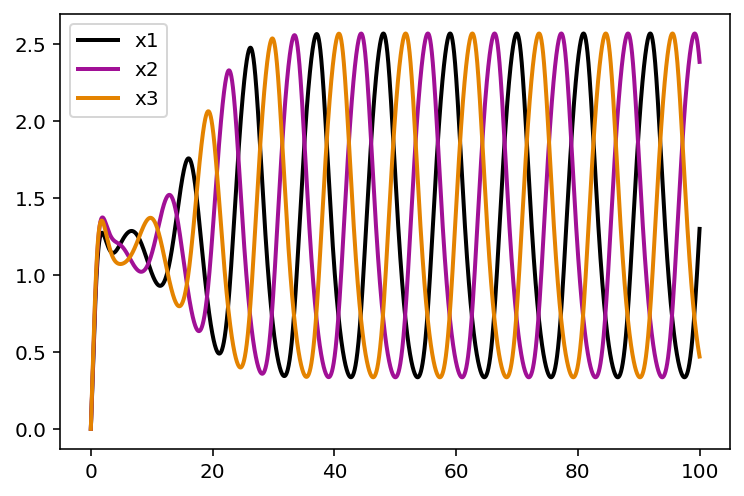

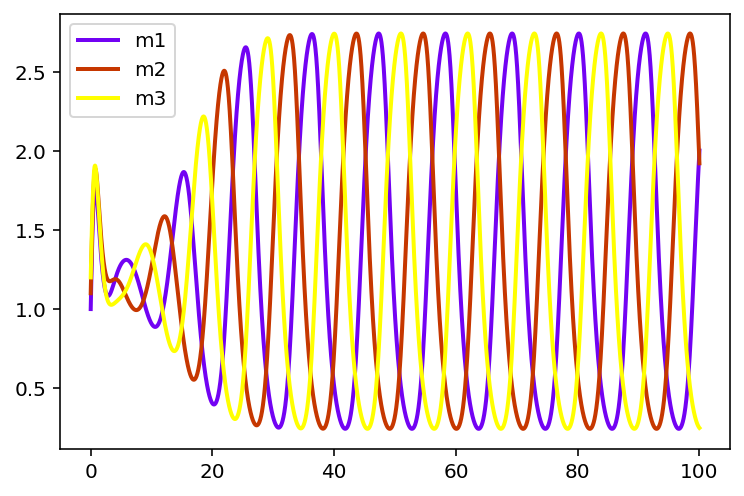

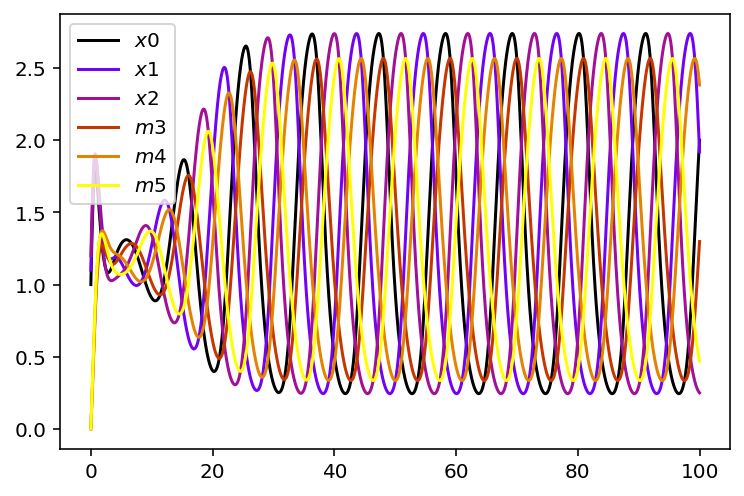

In [211]:
n=3.
k=1
d_m=1.

# protein production and decay rate
log_dp=1
log_gp=1

#mRNA production rate
log_gm=3      

y0=[1,1.1,1.2,0,0,0]

repls = HillRepressilator(log_gm, log_gp, d_m, log_dp, n, k, y0)

params = (log_gm, log_gp, d_m, log_dp, n, k)

# [time, ysol]
[tsolve, soln] = HillRepressilator.run(repls, y0, 100, 10000, params)
HillRepressilator.plot(repls, tsolve, soln, "True", "False")

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

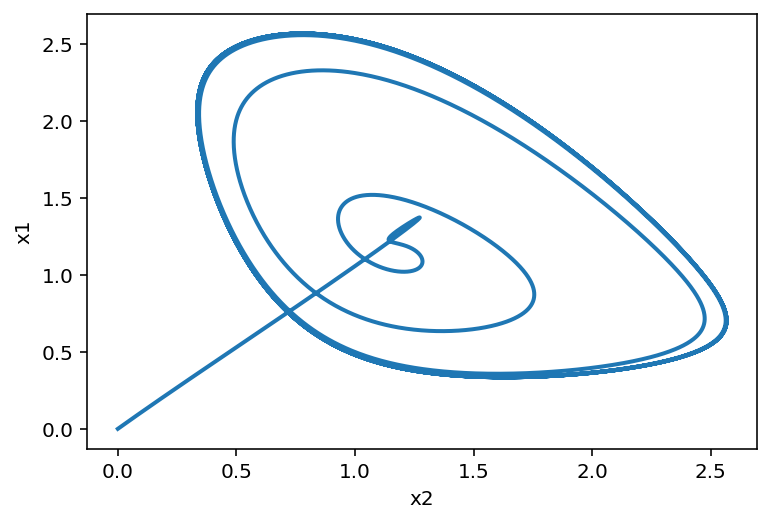

In [212]:
repls = HillRepressilator(log_gm, log_gp, d_m, log_dp, n, k, y0)
params = (log_gm, log_gp, d_m, log_dp, n, k)
[tsolve, soln] = HillRepressilator.run(repls, y0, 100, 10000, params)
m1, m2, m3, x1, x2, x3 = soln

HillRepressilator.plot_phase_diagram(repls, x1, x2, "x1", "x2")

<Figure size 864x864 with 0 Axes>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

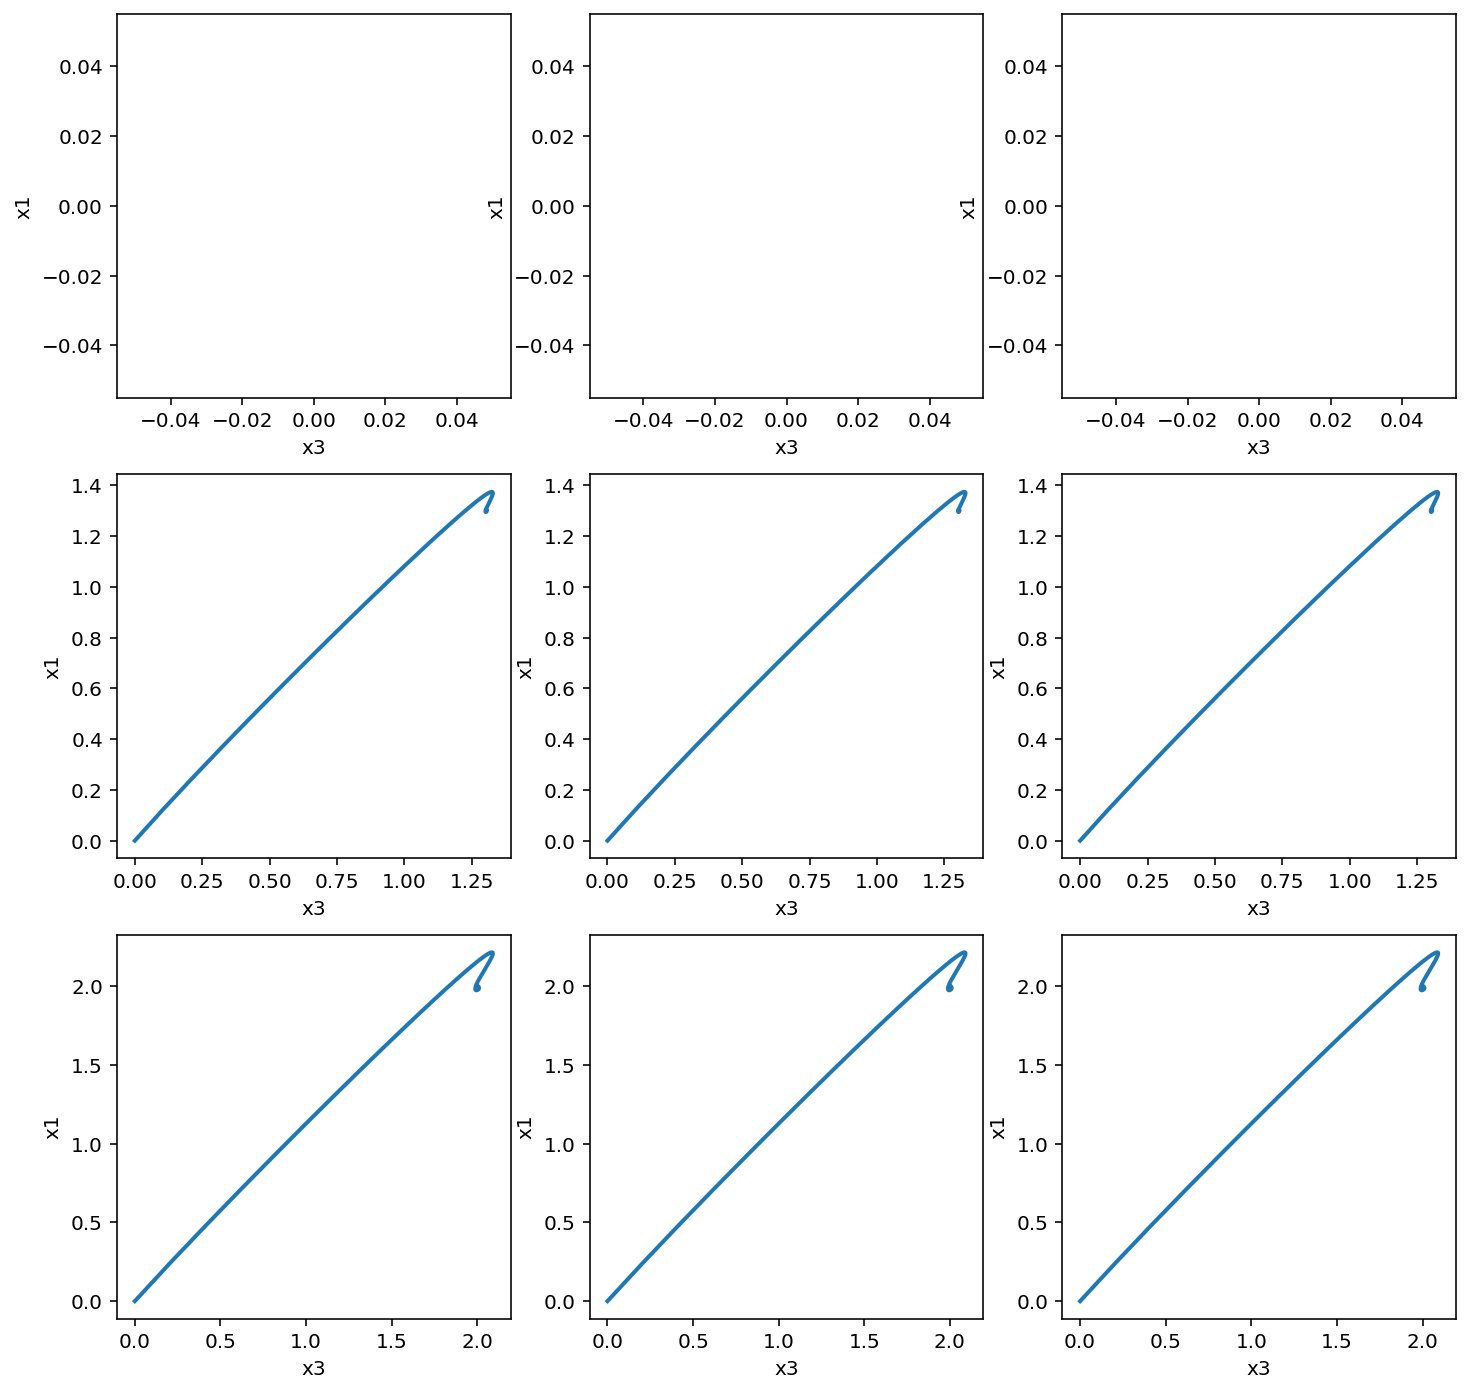

In [213]:
k=1
d_m=1.
y0=[1,1.1,1.2,0,0,0]

# protein production and decay rate
# ranging from -3 to 0
log_dp=1.
log_gp=1.

# mRNA production rate
# ranging from 0 to 3
log_gm=3     

repls1x1 = []
repls1x2 = []
repls1x3 = []
repls2x1 = []
repls2x2 = []
repls2x3 = []
repls3x1 = []
repls3x2 = []
repls3x3 = []

n = 1
for log_gp in range(0,3):
    for log_dm in range(-2,1):
        repls = HillRepressilator(log_gm, log_gp, d_m, log_gp, n, k, y0)
        params = (log_gm, log_gp, d_m, log_dp, n, k)
        [tsolve, soln] = HillRepressilator.run(repls, y0, 100, 1000, params)
        m1, m2, m3, x1, x2, x3 = soln
        repls1x1.append(x1)
        repls1x3.append(x3)

n = 2
for log_gp in range(0,3):
    for log_dm in range(-2,1):
        repls = HillRepressilator(log_gm, log_gp, d_m, log_gp, n, k, y0)
        params = (log_gm, log_gp, d_m, log_dp, n, k)
        [tsolve, soln] = HillRepressilator.run(repls, y0, 100, 1000, params)
        repls2.append(soln)
        repls2x1.append(x1)
        repls2x3.append(x3)
        
n = 3
for log_gp in range(0,3):
    for log_dm in range(-2,1):
        repls = HillRepressilator(log_gm, log_gp, d_m, log_gp, n, k, y0)
        params = (log_gm, log_gp, d_m, log_dp, n, k)
        [tsolve, soln] = HillRepressilator.run(repls, y0, 100, 1000, params)
        repls3.append(soln)
        repls3x1.append(x1)
        repls3x3.append(x3)
        
import matplotlib.pylab as plb
        
        
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilator.plot_phase_diagram(repls, repls1x1[i], repls1x3[i],
                                         "x1", "x3")       


<Figure size 864x864 with 0 Axes>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

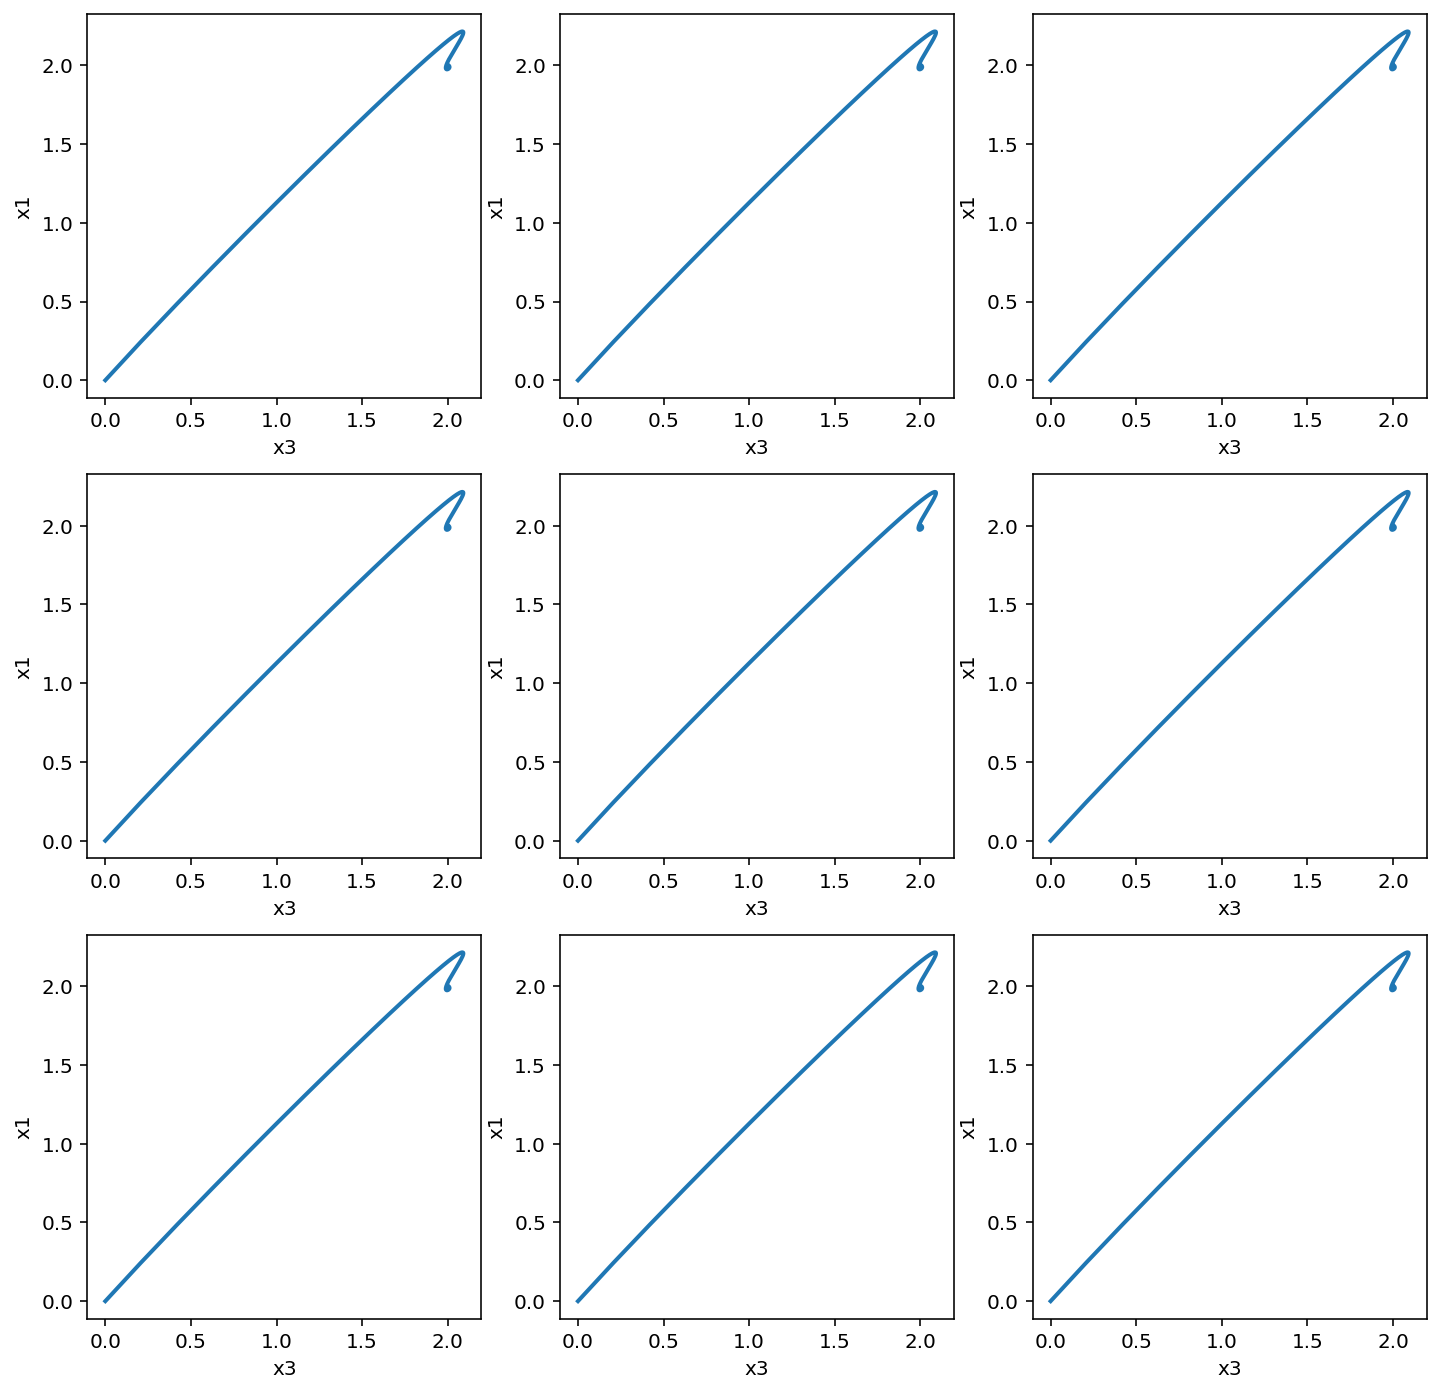

In [214]:
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilator.plot_phase_diagram(repls, repls2x1[i], repls2x3[i],
                                         "x1", "x3")

<Figure size 864x864 with 0 Axes>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

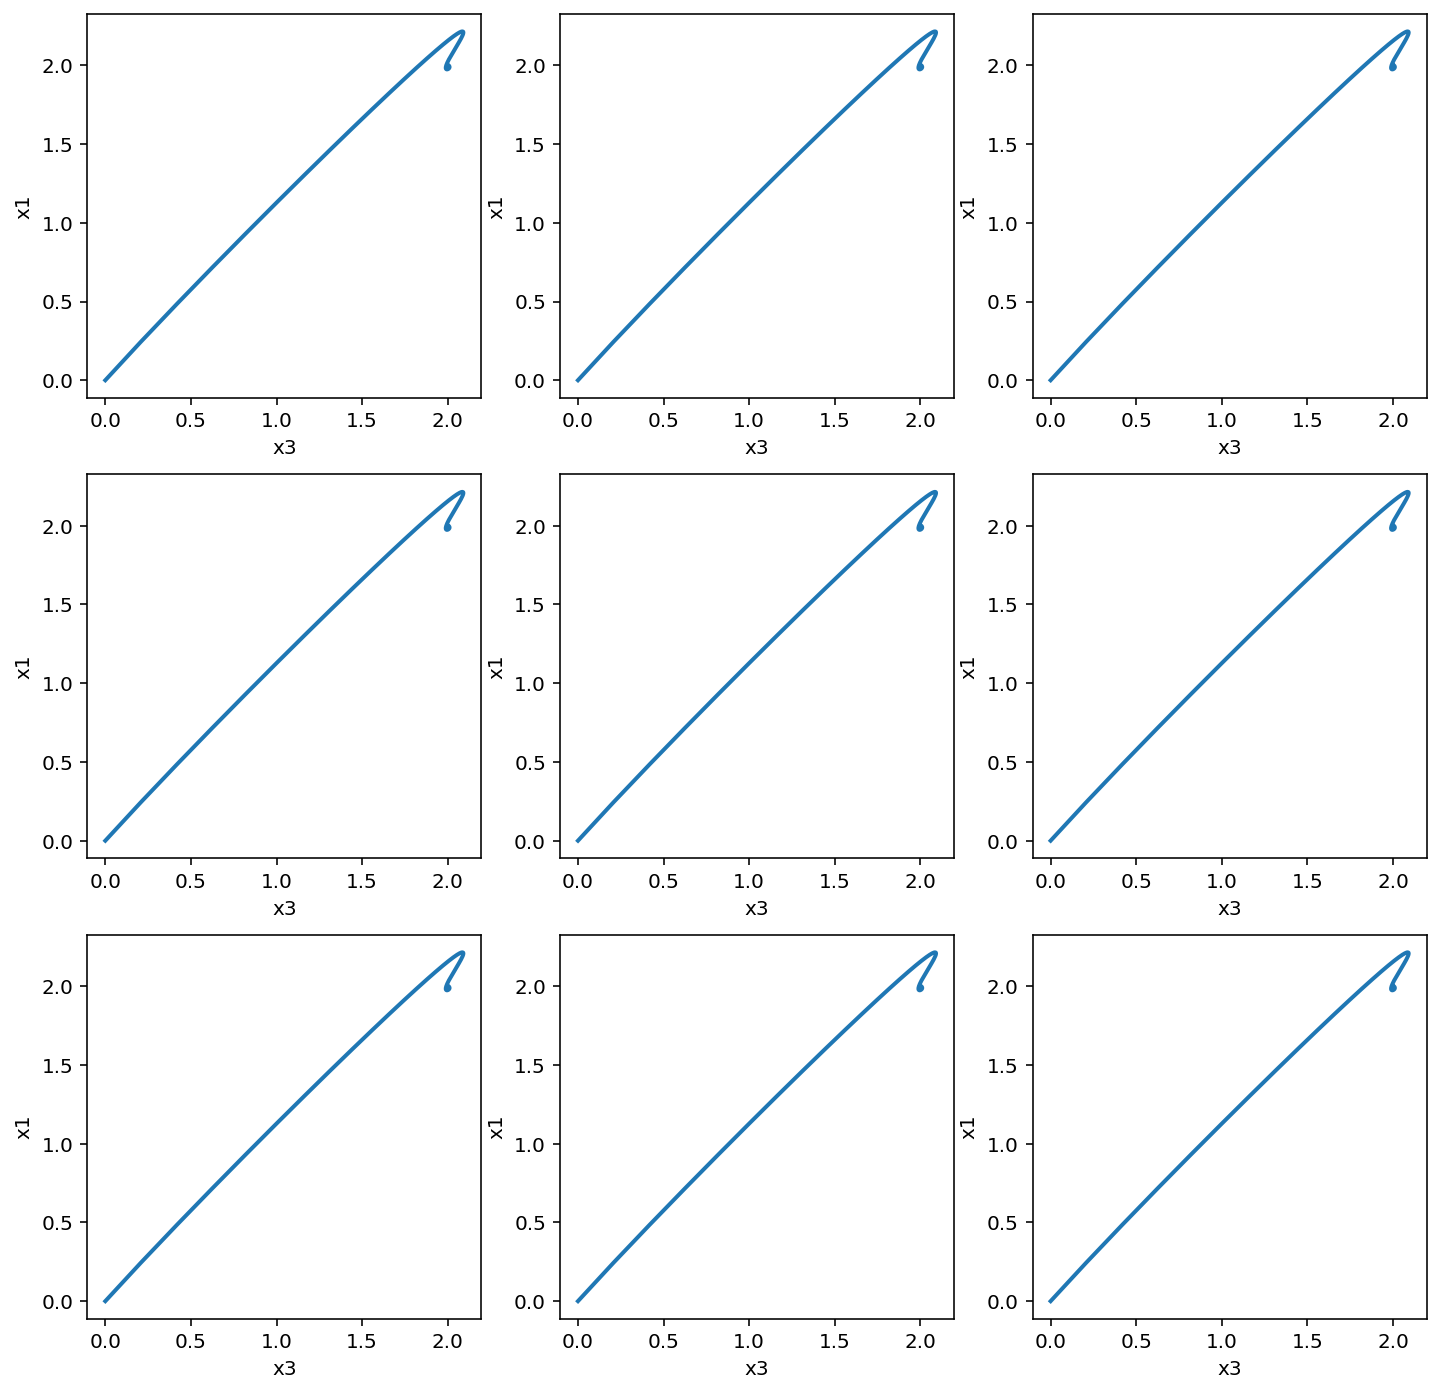

In [215]:
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilator.plot_phase_diagram(repls, repls3x1[i], repls3x3[i],
                                         "x1", "x3")